# Projeto: predição de risco de acidente vascular cerebral (AVC)

O acidente vascular cerebral (AVC) é uma condição médica grave que ocorre quando há interrupção ou redução do fluxo sanguíneo para uma parte do cérebro, resultando em danos às células cerebrais. Representa uma das principais causas de morte no mundo e pode ter consequências graves, tanto físicas quanto cognitivas. Diante de sua alta incidência e impacto, a previsão do risco de desenvolvimento de AVC torna-se essencial para a adoção de medidas preventivas eficazes. Identificar precocemente indivíduos em maior risco permite intervenções clínicas e mudanças no estilo de vida que podem reduzir a ocorrência de novos casos e melhorar a qualidade de vida da população.

O conjunto de dados utilizado neste projeto foi construído com base em literatura médica, consultas a especialistas e modelagem estatística. As distribuições e relações de características foram inspiradas em observações clínicas do mundo real, garantindo validade médica. Nele há 70.000 registros e 18 características relacionadas a fatores de risco para desfecho de acidente vascular cerebral.

Fonte dos dados: [Kaggle](https://www.kaggle.com/datasets/mahatiratusher/stroke-risk-prediction-dataset)

## Dicionário de dados


`Chest Pain`: dor no peito -> 0 = Não, 1 = Sim;

`Shortness of Breath`: dificuldade para respirar -> 0 = Não, 1 = Sim;

`Irregular Heartbeat`: batimento cardíaco irregular -> 0 = Não, 1 = Sim;

`Fatigue & Weakness`: fadiga persistente e fraqueza muscular -> 0 = Não, 1 = Sim;

`Dizziness`: tonturas frequentes -> 0 = Não, 1 = Sim;

`Swelling (Edema)`: inchaço nas extremidades devido à retenção de líquidos -> 0 = Não, 1 = Sim;

`Pain in Neck/Jaw/Shoulder/Back`: dor no pescoço, mandíbula, ombro e costas -> 0 = Não, 1 = Sim;

`Excessive Sweating`: suor excessivo -> 0 = Não, 1 = Sim;

`Persistent Cough`: tosse crônica -> 0 = Não, 1 = Sim;

`Nausea/Vomiting`: náuseas ou vômitos frequentes -> 0 = Não, 1 = Sim;

`High Blood Pressure`: pressão alta -> 0 = Não, 1 = Sim;

`Chest Discomfort (Activity)`: desconforto no peito durante atividade física -> 0 = Não, 1 = Sim;

`Cold Hands/Feet`: frequentemente está com extremidades (mãos e pés) frias -> 0 = Não, 1 = Sim;

`Snoring/Sleep Apnea`: apneia do sono -> 0 = Não, 1 = Sim;

`Anxiety/Feeling of Doom`: ansiedade frequente ou sensação de desgraça iminente -> 0 = Não, 1 = Sim;

`Stroke Risk (%)`: risco percentual estimado de ter um acidente vascular cerebral -> valor contínuo de porcentagem (0-100%);

`At Risk (Binary)`: classificada como risco de acidente vascular cerebral -> 0 = Não, 1 = Sim;

`Age`: idade do indivíduo -> valor contínuo;

## Importações e ajustes iniciais

In [ ]:
# Frameworks
import numpy as np
import pandas as pd

# Gráficas
import matplotlib.pyplot as plt

# Modelagem
from joblib import dump
from lightgbm import LGBMClassifier
import shap
from sklearn.calibration import calibration_curve
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    RobustScaler,
    StandardScaler
)
from xgboost import XGBClassifier

# Configurações
from src.config import DADOS_LIMPOS, MODELO_FINAL_CLF
from src.clf_graphics import plot_compare_models_metrics
from src.clf_models import (
    RANDOM_STATE,
    grid_search_cv_classifier,
    organize_results,
    train_validate_classif_model
)

# Avisos
import warnings

In [2]:
# Ajustes
warnings.filterwarnings("ignore")
pd.options.display.float_format = "{:,.2f}".format

## Modelagem - Classificação

### Verificação inicial dos dados

In [3]:
df = pd.read_parquet(DADOS_LIMPOS)

In [4]:
df.head()

,age,anxiety_feeling_of_doom,at_risk,chest_discomfort_activity,chest_pain,cold_hands_feet,dizziness,excessive_sweating,fatigue_weakness,high_blood_pressure,irregular_heartbeat,nausea_vomiting,pain_in_neck_jaw_shoulder_back,persistent_cough,shortness_of_breath,snoring_sleep_apnea,stroke_risk,swelling_edema
0,54,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,58.00,No
1,49,No,No,No,No,Yes,No,No,No,Yes,Yes,No,No,No,No,Yes,40.50,Yes
2,62,No,Yes,No,Yes,No,Yes,No,Yes,No,No,No,No,Yes,No,Yes,52.00,Yes
3,48,No,Yes,No,Yes,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,60.00,Yes
4,61,Yes,Yes,No,No,No,No,Yes,No,Yes,Yes,Yes,No,No,No,Yes,56.50,Yes


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68979 entries, 0 to 68978
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   age                             68979 non-null  int8    
 1   anxiety_feeling_of_doom         68979 non-null  category
 2   at_risk                         68979 non-null  category
 3   chest_discomfort_activity       68979 non-null  category
 4   chest_pain                      68979 non-null  category
 5   cold_hands_feet                 68979 non-null  category
 6   dizziness                       68979 non-null  category
 7   excessive_sweating              68979 non-null  category
 8   fatigue_weakness                68979 non-null  category
 9   high_blood_pressure             68979 non-null  category
 10  irregular_heartbeat             68979 non-null  category
 11  nausea_vomiting                 68979 non-null  category
 12  pain_in_neck_jaw_s

### Comparação inicial entre modelos

Primeiro serão definidas algumas variáveis úteis para todo o notebook e serão separados os dados de treino e teste. Como este será um modelos de classificação, também será excluída a coluna que indica o desfecho por meio de porcentagem.

Durante o treinamento será realizada uma validação cruzada para melhor treinar o modelo, porém neste momento serão serparados dados de treino e dados de teste para somente os dados de treino passarem pela validação cruzada, enquanto os dados de teste serão passados para o modelo apenas ao final, para validar a performance do treinamento realizado.

In [6]:
df.drop(columns="stroke_risk", inplace=True)

In [7]:
numeric_column = ["age"]
target_column_clf = "at_risk"
binary_columns = [column for column in df.columns if column not in (numeric_column + [target_column_clf])]

In [8]:
X = df.drop(columns=target_column_clf)
y = df[target_column_clf]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

Serão criados dois tipos de preprocessamento: um simples, somente para as features categóricas ou categóricas com padronização simples da numérica (de acordo com o mínimo necessário para o modelo) e outro com as categóricas e padronização mais robusta da numérica.

Inicialmente, para comparação entre os modelos, será usado apenas o simples. Após escolha do melhor modelo, na parte de otimizações, será avaliado qual preprocessamento performa melhor.

In [10]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [11]:
preprocessing_cat = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
    ],
    remainder="passthrough"
)

preprocessing_basic = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("standard_scaler", StandardScaler(), numeric_column),
    ],
    remainder="passthrough"
)

preprocessing_robust = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("robust_scaler", RobustScaler(), numeric_column),
    ],
    remainder="passthrough"
)


Neste momento serão avaliados vários modelos de classificação sem otimizações, para verificar quais performam melhor. Desta avaliação derivará o modelo (ou mais de um, se houver performances semelhantes) que será escolhido para etapas futuras de otimização de hiperparâmetros.

Para comparação foram escolhidos alguns modelos de árvore, pois são os que costumam performar melhor em dados da área da saúde, um modelo de regressão para classificação e um modelo que trabalha com a ideia de distância entre os pontos.

In [12]:
clfs = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_basic,
        "classifier": LogisticRegression()
    },
    "RandomForestClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "kNN": {
        "preprocessor": preprocessing_basic,
        "classifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    },
}

In [13]:
kf = StratifiedKFold(n_splits=7, shuffle=True, random_state=RANDOM_STATE)

In [14]:
results = {
    model_name: train_validate_classif_model(X_train, y_train, kf, **classifier)
    for model_name, classifier in clfs.items()
}

df_results = organize_results(results)

In [15]:
df_results.groupby("model").mean().sort_values("test_roc_auc")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.01,0.02,0.54,0.50,0.65,0.65,0.64,0.50,0.65,0.03
kNN,0.34,5.85,0.90,0.89,0.92,0.92,0.93,0.95,0.96,6.19
RandomForestClassifier,7.10,1.01,0.95,0.94,0.96,0.95,0.96,0.99,0.99,8.11
LGBMClassifier,1.37,0.19,0.98,0.97,0.98,0.98,0.99,1.00,1.00,1.56
XGBClassifier,1.12,0.15,1.00,0.99,1.00,1.00,1.00,1.00,1.00,1.27
LogisticRegression,0.58,0.17,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.75


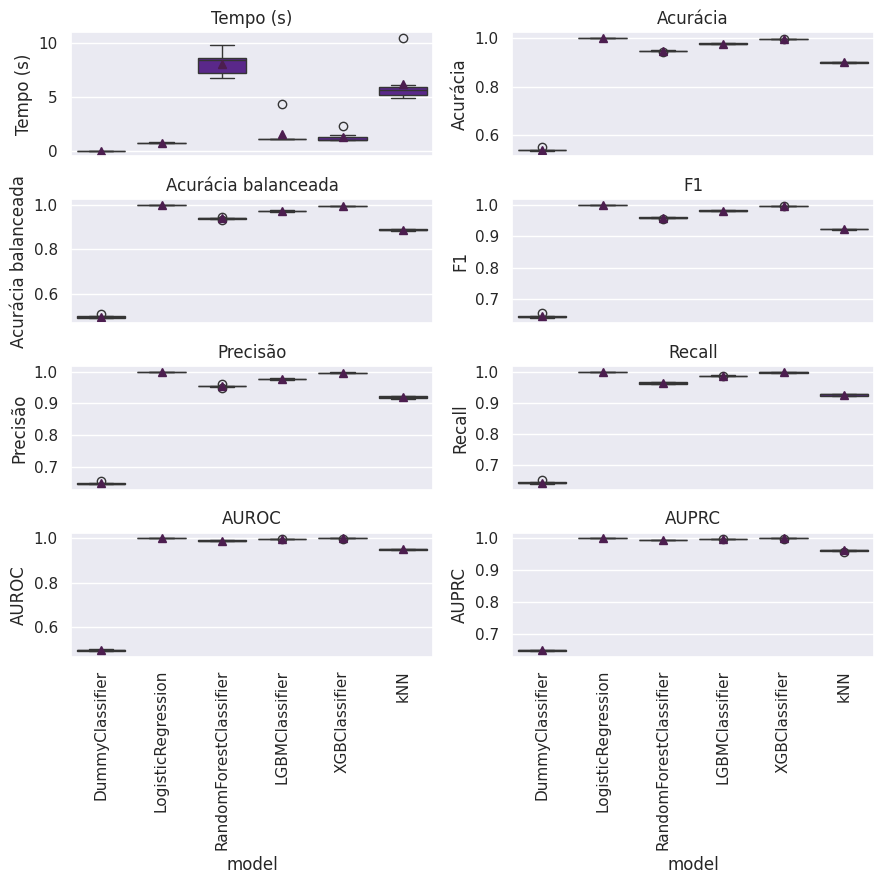

In [16]:
plot_compare_models_metrics(df_results)

Todos os modelos performaram muito bem e muito melhor que o dummy, sendo o desempate possível mais por questão de tempo de execução, tendo LogisticRegression, XGBoost e LightGBM como melhores. Como a performance está muito boa mesmo sem otimização de hiperparâmetros, pode-se verificar se é possível simplificar mais o modelo reduzindo a quantidade de features a serem imputadas.

Acredito que este cenário de todos os modelos irem muito bem não costuma ser muito comum para dados reais, então mesmo que a seleção de features diminua um pouco a performance, seguirei com ela apenas para poder treinar o uso de otimização de hiperparâmetros, dado que este projeto tem a finalidade de estudo.



### Seleção de features

Como comentado acima, dada a performance muito boa da maioria dos modelos, será feita uma seleção de features para diminuir a complexidade do modelo, podendo também evitar overfitting.

In [17]:
NUMBER_FINAL_FEATURES = 8

In [18]:
preprocessing_kbest = preprocessing_basic
X_train_scaled = preprocessing_kbest.fit_transform(X_train, y_train)

selector_mi = SelectKBest(mutual_info_classif, k=NUMBER_FINAL_FEATURES)
selector_mi.fit_transform(X_train_scaled, y_train)

selected_mask = selector_mi.get_support()
feature_names = preprocessing_kbest.get_feature_names_out()
selected_feature_names = feature_names[selected_mask]

print("Features selecionadas:", selected_feature_names)

Features selecionadas: ['ohe__chest_pain_Yes' 'ohe__cold_hands_feet_Yes'
 'ohe__fatigue_weakness_Yes' 'ohe__irregular_heartbeat_Yes'
 'ohe__persistent_cough_Yes' 'ohe__shortness_of_breath_Yes'
 'ohe__snoring_sleep_apnea_Yes' 'standard_scaler__age']


In [19]:
columns_to_keep = []

for column in selected_feature_names:
  column = column.split("__")[1].split("_Yes")[0]
  columns_to_keep.append(column)

print("Colunas que serão mantidas:", columns_to_keep)

Colunas que serão mantidas: ['chest_pain', 'cold_hands_feet', 'fatigue_weakness', 'irregular_heartbeat', 'persistent_cough', 'shortness_of_breath', 'snoring_sleep_apnea', 'age']


Dada a seleção realizada, os dados de X tanto de treino quanto de teste serão alterados para mater apenas as features selecionadas.

In [20]:
X_train = X_train.drop(columns=[column for column in X_train.columns if column not in columns_to_keep])
X_test = X_test.drop(columns=[column for column in X_test.columns if column not in columns_to_keep])

Os mesmos modelos serão novamente comparados, desta vez utilizando os dados de X com a seleção de features.

In [21]:
binary_columns = [column for column in X_train.columns if column not in (numeric_column)]

In [22]:
preprocessing_cat = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
    ],
    remainder="passthrough"
)

preprocessing_basic = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("standard_scaler", StandardScaler(), numeric_column),
    ],
    remainder="passthrough"
)

preprocessing_robust = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first"), binary_columns),
        ("robust_scaler", RobustScaler(), numeric_column),
    ],
    remainder="passthrough"
)

In [23]:
clfs_select = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_basic,
        "classifier": LogisticRegression()
    },
    "RandomForestClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)
    },
    "XGBClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    },
    "kNN": {
        "preprocessor": preprocessing_basic,
        "classifier": KNeighborsClassifier(n_neighbors=3, weights="distance"),
    },
}

In [24]:
results_select = {
    model_name: train_validate_classif_model(X_train, y_train, kf, **classifier)
    for model_name, classifier in clfs_select.items()
}

df_results_select = organize_results(results_select)

In [25]:
df_results_select.groupby("model").mean().sort_values("test_roc_auc")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.00,0.02,0.54,0.50,0.65,0.65,0.65,0.50,0.65,0.02
kNN,0.19,0.86,0.83,0.81,0.87,0.87,0.86,0.87,0.89,1.04
RandomForestClassifier,2.68,0.39,0.84,0.82,0.87,0.87,0.88,0.91,0.94,3.07
XGBClassifier,0.75,0.13,0.86,0.84,0.89,0.89,0.90,0.93,0.96,0.88
LGBMClassifier,0.59,0.15,0.86,0.85,0.89,0.89,0.90,0.93,0.96,0.74
LogisticRegression,0.17,0.10,0.86,0.85,0.89,0.89,0.90,0.93,0.96,0.27


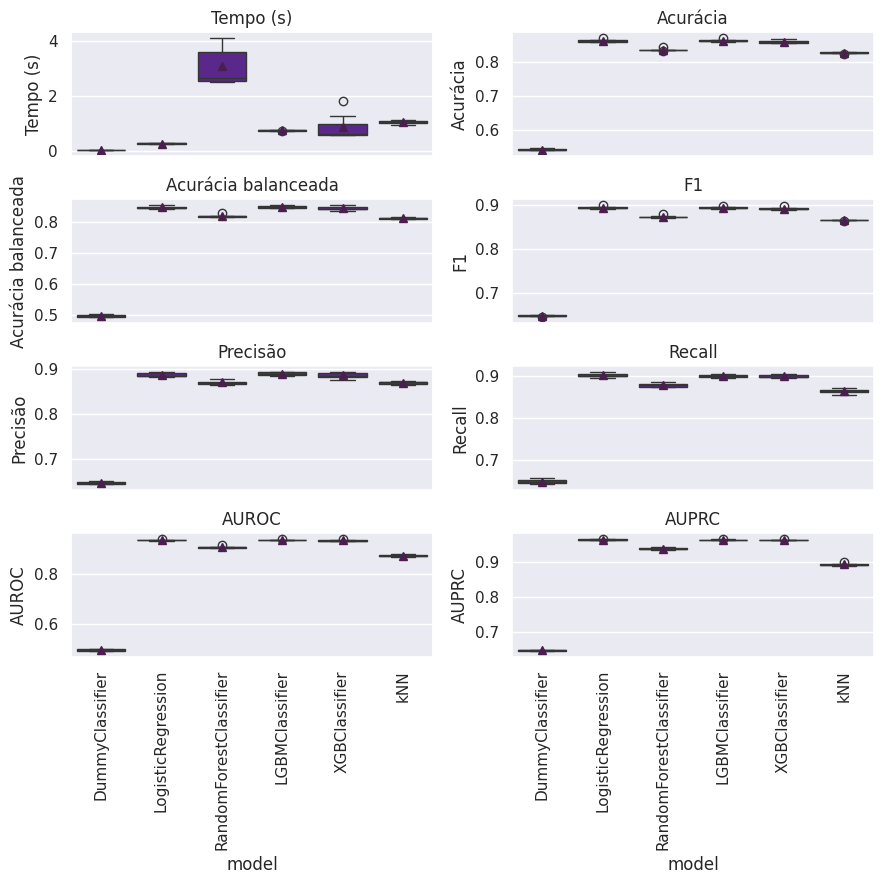

In [26]:
plot_compare_models_metrics(df_results_select)

Após a seleção de features as métricas diminuíram um pouco, mas para uma simplificação de 18 para 8 features, não foi uma queda tão acentuada nos valores.

Os melhores modelos praticamente empatados em performance e com tempo de execução menores foram LogisticRegression, LightGBM e XGBoost.

Deste modo, a seguir serão otimizados hiperparâmetros desses três modelos, que serão comparados ao final para decidir o melhor. Além disso, serão mantidas apenas as 8 features selecionadas.

### Otimização de hiperparâmetros

#### LogisticRegression

In [30]:
param_grid_lr = {
    "clf__C": [0.1, 1, 10, 100],
    "clf__penalty": ["l1", "l2", None],
    "clf__class_weight": [None, "balanced"],
    "preprocessor": [preprocessing_basic, preprocessing_robust],
}

In [31]:
clf_lr = LogisticRegression(solver="saga", random_state=RANDOM_STATE)

grid_search_lr = grid_search_cv_classifier(clf_lr, param_grid_lr, kf, preprocessing_basic)

grid_search_lr.fit(X_train, y_train)

Fitting 7 folds for each of 48 candidates, totalling 336 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['chest_pain',
                                                                          'cold_hands_feet',
                                                                          'fatigue_weakness',
                                                                          'irregular_heartbeat',
                                                                          'persistent_cough',
                                                                          'shortness_of_breath',
                                                                          'snoring_sleep_apnea']),
                                                                        ('stan...
                                                            transformers=[('ohe',
                                                                           OneHotEncoder(drop='first'),
                                                                           ['chest_pain',
                                                                            'cold_hands_feet',
                                                                            'fatigue_weakness',
                                                                            'irregular_heartbeat',
                                                                            'persistent_cough',
                                                                            'shortness_of_breath',
                                                                            'snoring_sleep_apnea']),
                                                                          ('robust_scaler',
                                                                           RobustScaler(),
                                                                           ['age'])])]},
             refit='roc_auc',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

In [32]:
grid_search_lr.best_params_

{'clf__C': 10,
 'clf__class_weight': None,
 'clf__penalty': 'l2',
 'preprocessor': ColumnTransformer(remainder='passthrough',
                   transformers=[('ohe', OneHotEncoder(drop='first'),
                                  ['chest_pain', 'cold_hands_feet',
                                   'fatigue_weakness', 'irregular_heartbeat',
                                   'persistent_cough', 'shortness_of_breath',
                                   'snoring_sleep_apnea']),
                                 ('robust_scaler', RobustScaler(), ['age'])])}

Inicialmente foi testado o param_grid com apenas "elasticnet" e None e como o resultado foi "elasticnet" com "l1_ratio" de 0.85 (máximo testado), significa que a regularização está tendendo mais para l1. Então, foi testado novamente com apenas "l1", "l2" e None e o resultado obtido então prevaleceu "l2" com um "C" maior do que o obtido no "elasticnet" (atual foi 10 e inicial foi 1).

Foi realizado o grid_search desse modo por etapas apenas para não demorar muito tempo na etapa de fit, mas poderia ter sido feito tudo de uma vez.

In [33]:
grid_search_lr.best_score_

np.float64(0.9334813557352887)

Com hiperparâmetros otimizados não parece ter havido muita mudança de score (AUROC), mas eles serão mantidos para a avaliação final.

#### LightGBM

In [34]:
scale_pos_weight = np.bincount(y_train)[0] / np.bincount(y_train)[1]

param_grid_lgbm = {
    "clf__max_depth": [3, 6, 10],
    #"clf__num_leaves": [10, 25, 50],  # Número máximo de folhas por árvore
    #"clf__min_child_samples": [10, 20, 50],  # Mínimo de amostras em um nó folha
    # "clf__min_split_gain": [0.0, 0.1, 0.3],  # Redução mínima de perda para divisão
    # "clf__subsample": [0.4, 0.7, 1.0],  # Proporção de amostras usadas para cada árvore
    # "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para construção de cada árvore
    "clf__learning_rate": [0.1, 0.3, 0.5],
    "clf__n_estimators": [10, 50, 100],
    # "clf__reg_alpha": [0.0, 0.1, 1.0],  # Regularização L1
    # "clf__reg_lambda": [0.0, 0.1, 1.0],  # Regularização L2
    "clf__scale_pos_weight": [1, scale_pos_weight],
    # "preprocessor": [preprocessing_cat, preprocessing_basic, preprocessing_robust],
}

In [35]:
clf_lgbm = LGBMClassifier(random_state=RANDOM_STATE, n_jobs=-1, verbose=-1)

In [36]:
grid_search_lgbm = grid_search_cv_classifier(clf_lgbm, param_grid_lgbm, kf, preprocessing_cat)

grid_search_lgbm.fit(X_train, y_train)

Fitting 7 folds for each of 54 candidates, totalling 378 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['chest_pain',
                                                                          'cold_hands_feet',
                                                                          'fatigue_weakness',
                                                                          'irregular_heartbeat',
                                                                          'persistent_cough',
                                                                          'shortness_of_breath',
                                                                          'snoring_sleep_apnea'])])),
                                       ('c...
                                        LGBMClassifier(n_jobs=-1,
                                                       random_state=42,
                                                       verbose=-1))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.1, 0.3, 0.5],
                         'clf__max_depth': [3, 6, 10],
                         'clf__n_estimators': [10, 50, 100],
                         'clf__scale_pos_weight': [1,
                                                   np.float64(0.5403489183531054)]},
             refit='roc_auc',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

Os itens comentados no param_grid são outros hiperparâmetros comuns de serem testados e que só não foram testados neste projeto por questão de tempo de execução do fit.

In [37]:
grid_search_lgbm.best_params_

{'clf__learning_rate': 0.5,
 'clf__max_depth': 3,
 'clf__n_estimators': 50,
 'clf__scale_pos_weight': 1}

In [38]:
grid_search_lgbm.best_score_

np.float64(0.9335634689185619)

Com hiperparâmetros otimizados não parece ter havido muita mudança de score (AUROC), mas eles serão mantidos para a avaliação final. Se testar outros hiperparâmentros (por exemplo os que foram comentados) pode ser que haja alguma melhora.

#### XGBoost

In [39]:
param_grid_xgb = {
    "clf__max_depth": [3, 6, 10],
    # "clf__min_child_weight": [1, 3, 5],  # Peso mínimo de uma folha
    # "clf__gamma": [0, 0.1, 0.3],  # Redução mínima de perda para uma divisão
    # "clf__subsample": [0.6, 0.8, 1.0],  # Proporção de amostras usadas para cada árvore
    # "clf__colsample_bytree": [0.6, 0.8, 1.0],  # Proporção de features para cada árvore
    "clf__learning_rate": [0.1, 0.3, 0.5],
    "clf__n_estimators": [10, 50, 100],  # Número de árvores
    # "clf__reg_lambda": [1, 2, 5],  # Regularização L2
    # "clf__reg_alpha": [0, 0.5, 1],  # Regularização L1
    "clf__scale_pos_weight": [1, scale_pos_weight],
    # "preprocessor": [preprocessing_cat, preprocessing_basic, preprocessing_robust],
}

In [40]:
clf_xgb = XGBClassifier(random_state=RANDOM_STATE, n_jobs=-1)

In [41]:
grid_search_xgb = grid_search_cv_classifier(clf_xgb, param_grid_xgb, kf, preprocessing_cat)

grid_search_xgb.fit(X_train, y_train)

Fitting 7 folds for each of 54 candidates, totalling 378 fits


GridSearchCV(cv=StratifiedKFold(n_splits=7, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first'),
                                                                         ['chest_pain',
                                                                          'cold_hands_feet',
                                                                          'fatigue_weakness',
                                                                          'irregular_heartbeat',
                                                                          'persistent_cough',
                                                                          'shortness_of_breath',
                                                                          'snoring_sleep_apnea'])])),
                                       ('c...
                                                      n_jobs=-1,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'clf__learning_rate': [0.1, 0.3, 0.5],
                         'clf__max_depth': [3, 6, 10],
                         'clf__n_estimators': [10, 50, 100],
                         'clf__scale_pos_weight': [1,
                                                   np.float64(0.5403489183531054)]},
             refit='roc_auc',
             scoring=['accuracy', 'balanced_accuracy', 'f1', 'precision',
                      'recall', 'roc_auc', 'average_precision'],
             verbose=1)

Os itens comentados no param_grid são outros hiperparâmetros comuns de serem testados e que só não foram testados neste projeto por questão de tempo de execução do fit.

In [42]:
grid_search_xgb.best_params_

{'clf__learning_rate': 0.5,
 'clf__max_depth': 3,
 'clf__n_estimators': 50,
 'clf__scale_pos_weight': np.float64(0.5403489183531054)}

In [43]:
grid_search_xgb.best_score_

np.float64(0.9335109778352234)

Com hiperparâmetros otimizados não parece ter havido muita mudança de score (AUROC), mas eles serão mantidos para a avaliação final. Se testar outros hiperparâmentros (por exemplo os que foram comentados) pode ser que haja alguma melhora.

#### Comparação final

In [44]:
clfs_final = {
    "DummyClassifier": {
        "preprocessor": None,
        "classifier": DummyClassifier(strategy="stratified")
    },
    "LogisticRegression": {
        "preprocessor": preprocessing_robust,
        "classifier": grid_search_lr.best_estimator_["clf"]
    },
    "LGBMClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": grid_search_lgbm.best_estimator_["clf"]
    },
    "XGBClassifier": {
        "preprocessor": preprocessing_cat,
        "classifier": grid_search_xgb.best_estimator_["clf"]
    },
}

In [45]:
results_final = {
    model_name: train_validate_classif_model(X_train, y_train, kf, **classifier)
    for model_name, classifier in clfs_final.items()
}

df_results_final = organize_results(results_final)

In [46]:
df_results_final.groupby("model").mean().sort_values("test_roc_auc")

,fit_time,score_time,test_accuracy,test_balanced_accuracy,test_f1,test_precision,test_recall,test_roc_auc,test_average_precision,time_seconds
model,,,,,,,,,,
DummyClassifier,0.01,0.03,0.54,0.50,0.65,0.65,0.65,0.50,0.65,0.03
LogisticRegression,0.43,0.07,0.86,0.85,0.89,0.89,0.90,0.93,0.96,0.50
XGBClassifier,0.27,0.07,0.84,0.85,0.87,0.92,0.84,0.93,0.96,0.35
LGBMClassifier,0.29,0.10,0.86,0.85,0.90,0.89,0.90,0.93,0.96,0.39


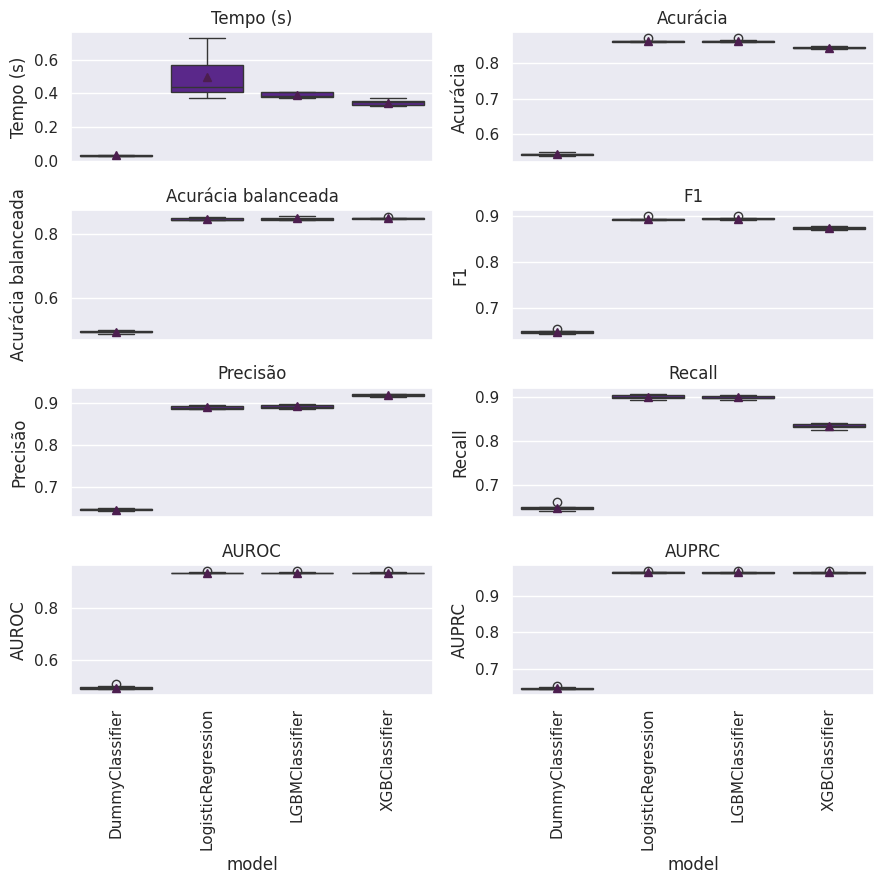

In [47]:
plot_compare_models_metrics(df_results_final)

A partir destes dados percebe-se que os modelos testados possuem performances muito semelhantes, assim como tempos de execução. Apenas por algumas poucas métricas serem ligeiramente melhores, o modelo final escolhoido é o LightGBM.

In [48]:
final_model = grid_search_lgbm.best_estimator_["clf"]

### Validação final

O modelo escolhido foi testado e otimizado com os dados de treino. Neste momento será realizada a validação final, com os dados de teste, nunca "vistos" pelo modelo.

In [49]:
preprocessing_cat.fit(X_train, y_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('ohe', OneHotEncoder(drop='first'),
                                 ['chest_pain', 'cold_hands_feet',
                                  'fatigue_weakness', 'irregular_heartbeat',
                                  'persistent_cough', 'shortness_of_breath',
                                  'snoring_sleep_apnea'])])

In [50]:
X_test_transformed = preprocessing_cat.transform(X_test)

In [51]:
le = LabelEncoder()
y_test = le.fit_transform(y_test)

In [52]:
y_pred = final_model.predict(X_test_transformed)

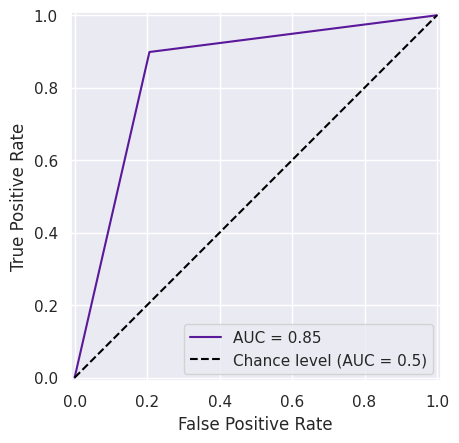

In [53]:
roc_auc = roc_auc_score(y_test, y_pred)
fpr, tpr, limiares = roc_curve(y_test, y_pred)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot(plot_chance_level=True)

Apesar do valor de AUC ter diminuído um pouco ao usar os dados finais de teste (era 0.93 e ficou 0.85), esse é um comportamento esperado e o valor de 0.85 ainda é um valor bom.

## Conclusão

O modelhor modelo defindo e validado pode passar por algumas avaliações finais apenas para visualizar sua performance.



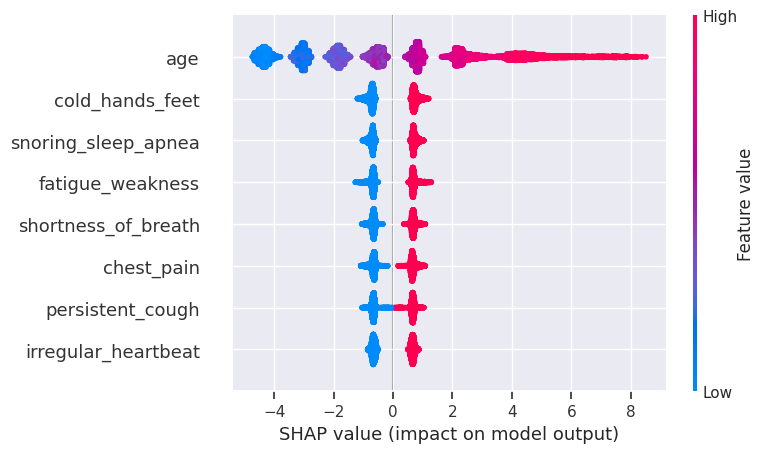

In [63]:
shap.initjs()

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_test_transformed)

shap.summary_plot(shap_values, X_test_transformed, columns_to_keep)

A partir do gráfico acima é possível ver que as features categóricas selecionadas diferenciam bem os grupos e a feature contínua "age" também possui alguns grupos bem distintos, apesar de não serem todas as faixas etárias boas para a separação.

Brier Score: 0.09877036766269598


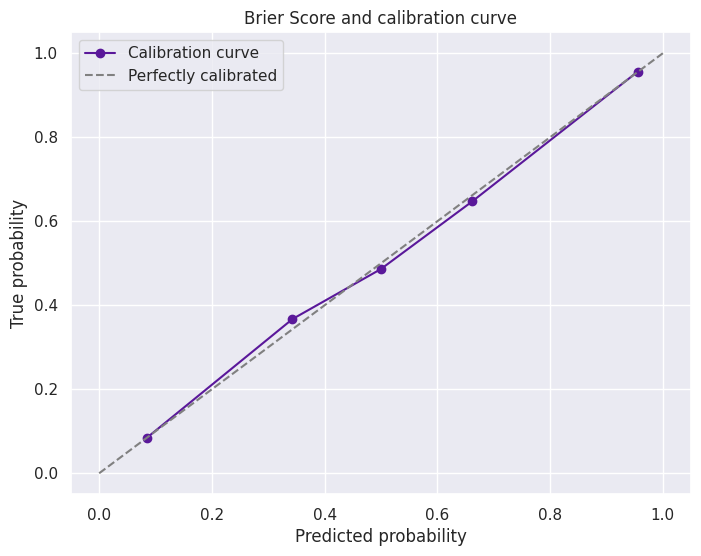

In [64]:
y_proba = final_model.predict_proba(X_test_transformed)[:, 1]

brier_score = brier_score_loss(y_test, y_proba)
print(f"Brier Score: {brier_score}")

prob_true, prob_pred = calibration_curve(y_test, y_proba, n_bins=5)

plt.figure(figsize=(8, 6))
plt.plot(prob_pred, prob_true, marker="o", linestyle="-", label="Calibration curve")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")
plt.xlabel("Predicted probability")
plt.ylabel("True probability")
plt.title("Brier Score and calibration curve")
plt.legend()
plt.grid(True)
plt.show()

A partir do gráfico acima é possível verificar que as previsões de probabilidade estão bem precisas, bem perto do que seria o melhor possível. Além disso, o valor do Brier Score também é bem baixo (0.099). Desse modo pode-se considerar o modelo final muito bem calibrado.

Foi definido e validado o melhor modelo para realizar as predições e os melhores parâmetros que ele pode ter para aprimorar o acerto do modelo. Desse modo, é possível usar o modelo obtido para prever novos dados. Para isso basta substituir os valores no "new_prediction" abaixo e executar.

In [67]:
new_prediction = pd.DataFrame([
    0, # chest_pain - 0 para não e 1 para sim
    0, # cold_hands_feet - 0 para não e 1 para sim
    1, # fatigue_weakness - 0 para não e 1 para sim
    1, # irregular_heartbeat - 0 para não e 1 para sim
    1, # persistent_cough - 0 para não e 1 para sim
    1, # shortness_of_breath - 0 para não e 1 para sim
    1, # snoring_sleep_apnea - 0 para não e 1 para sim
    63, # age
]).T

prediction = final_model.predict_proba(new_prediction)[0][1]

print(f"Probabilidade de chance de AVC de acordo com o modelo: {prediction:.2%}")

Probabilidade de chance de AVC de acordo com o modelo: 98.96%


Por fim, o modelo também será salvo, podendo ser implementado em outras aplicações.

In [ ]:
dump(final_model, MODELO_FINAL_CLF)